# **stacking_layer_1**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import math
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [4]:
def add_time_dummy(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: str(x.hour))
    input_data['month'] = input_data['datetime'].map(lambda x: str(x.month))
    input_data['minute'] = input_data['datetime'].map(lambda x: str(x.minute))
    input_data = pd.get_dummies(input_data, drop_first=False)
    return input_data

In [5]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [6]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [7]:
def to_zero(prediction):
    '''
    2012年から2015年の間で一度も発電量がなかった時間帯を0と予測するようにする
    '''
    mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,0,0,0,0,0,0,0,0,0,0])
    all_mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,0,0,0,0,0,0,0,0,0,0])
    length = int(len(prediction)/48)
    
    for i in range(length-1):
        all_mask = np.r_[all_mask, mask]
    
    return prediction * all_mask

In [8]:
def to_zero_df(train_prediction):
    '''
    発電しない時間帯を全て0にする
    '''
    for column in train_prediction.columns[1:]:
        tmp = train_prediction[column]
        tmp = np.array(tmp)
        tmp = to_zero(tmp)
        train_prediction[column] = tmp
    return train_prediction

In [9]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [10]:
def scaling_output(output_30, momentum=False):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    momentumで通年の傾向に従い発電量を割る
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]

    # 各年の減少傾向を考える
    if momentum:
        '''
        y_output["pre"] = y_output["SOLA0"+str(target_place)].shift(1)
        y_output["decline"] = y_output["SOLA0"+str(target_place)] / y_output["pre"]
        tendency= np.array(y_output["decline"].dropna())
        scale = 1
        for i in tendency:
            scale *= i
        scale = math.pow(scale, 1.0/3)
        tmp = tmp ** scale
        '''
        scale = sum_2015/sum_2012
        scale = math.pow(scale, 1.0/3)
        print("momentum : ", scale)
        tmp = tmp ** scale

    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [11]:
n_estimators = 20
max_depth = 5
max_features = "sqrt"

In [12]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **ランダムフォレスト**

### **浮島発電所について**

In [119]:
target_place = 1

In [120]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [121]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [122]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.ukishima.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.ukishima.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [123]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [124]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [125]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [126]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
layer_0_train_df = add_time_dummy(layer_0_train_df)
layer_0_test_df = add_time_dummy(layer_0_test_df)

In [127]:
layer_0_train_df.head()

,datetime,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [128]:
layer_0_test_df.head()

,datetime,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [129]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [130]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [25]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)), random_state=0)

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

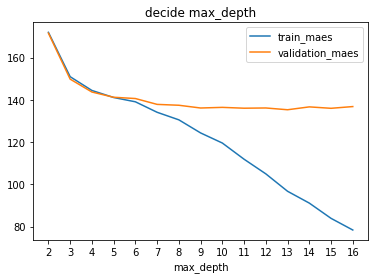

In [26]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [131]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/03 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [132]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 8, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

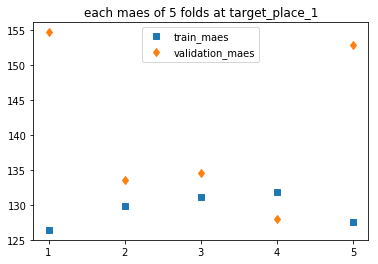

In [133]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [134]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **扇島発電所について**

In [135]:
target_place = 2

In [136]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [137]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [138]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.ougishima.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.ougishima.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [139]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [140]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [141]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [142]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
layer_0_train_df = add_time_dummy(layer_0_train_df)
layer_0_test_df = add_time_dummy(layer_0_test_df)

In [143]:
layer_0_train_df.head()

,datetime,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [144]:
layer_0_test_df.head()

,datetime,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [145]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [146]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [43]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)), random_state=0)

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

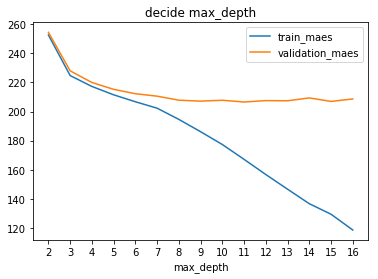

In [44]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [147]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/03 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [148]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 8, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

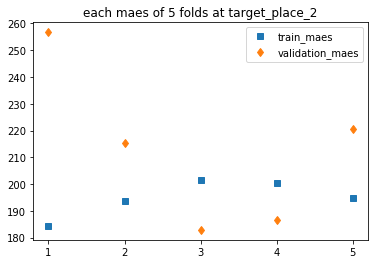

In [149]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [150]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **米倉山**

In [151]:
target_place = 3

In [152]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [153]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [154]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.yonekurayama.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.yonekurayama.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [155]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [156]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [157]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [158]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
layer_0_train_df = add_time_dummy(layer_0_train_df)
layer_0_test_df = add_time_dummy(layer_0_test_df)

In [159]:
layer_0_train_df.head()

,datetime,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [160]:
layer_0_test_df.head()

,datetime,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,minute_0,minute_30
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [161]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [162]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [61]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)), random_state=0)

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

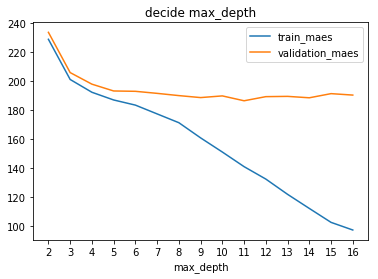

In [62]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [163]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/03 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [164]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 10, max_features=max_features)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i += 1
    train_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(all_X)
    predict_data["random_forest_"+str(i)+"-"+str(n_splits)+"folds"] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

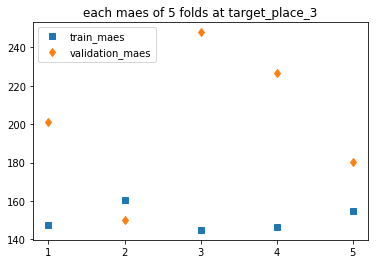

In [165]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [167]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **線形モデル(PLS)をつかう**

In [67]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

### **浮島**

In [68]:
target_place = 1

In [69]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [71]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.ukishima.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.ukishima.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [72]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [73]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [75]:
layer_0_train_df.head()

,datetime,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0


In [76]:
layer_0_test_df.head()

,datetime,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_1_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
# layer_0_train_df = add_time_dummy(layer_0_train_df)
# layer_0_test_df = add_time_dummy(layer_0_test_df)

In [78]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [79]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [80]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)
scaled_all_X = X_scaler.transform(all_X)
scaled_X_test = X_scaler.transform(X_test)

In [81]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [82]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

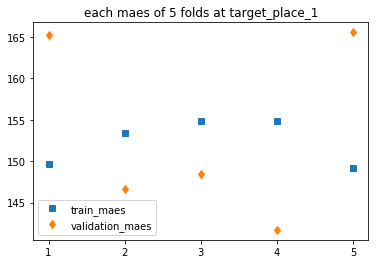

In [83]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [84]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **扇島**

In [85]:
target_place = 2

In [86]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [87]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [88]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.ougishima.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.ougishima.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [89]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [90]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [91]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [92]:
layer_0_train_df.head()

,datetime,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0


In [93]:
layer_0_test_df.head()

,datetime,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_2_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_2_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0


In [94]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
# layer_0_train_df = add_time_dummy(layer_0_train_df)
# layer_0_test_df = add_time_dummy(layer_0_test_df)

In [95]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [96]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [97]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)
scaled_all_X = X_scaler.transform(all_X)
scaled_X_test = X_scaler.transform(X_test)

In [98]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [99]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

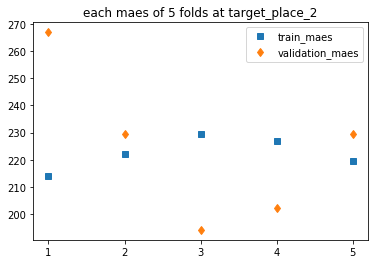

In [100]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [101]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

### **米倉山**

In [102]:
target_place = 3

In [103]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
# いろんなモデルの予測値の集合(学習用とテスト用)
syo_train = pd.read_csv("data/layer_0/syo/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_train['datetime'] = syo_train['datetime'].map(lambda x : pd.to_datetime(x))

syo_predict = pd.read_csv("data/layer_0/syo/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
syo_predict['datetime'] = syo_predict['datetime'].map(lambda x : pd.to_datetime(x))

In [105]:
# いろんなモデルの予測値の集合(学習用とテスト用)
yuge_train = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.crossval.yonekurayama.tsv", delimiter="\t")
yuge_train = yuge_train.dropna(axis=1)
yuge_train = yuge_train.rename(columns={"Unnamed: 0" : "datetime"})
yuge_train['datetime'] = yuge_train['datetime'].map(lambda x : pd.to_datetime(x))

yuge_predict = pd.read_csv("data/layer_0/yuge/dataset.predict_y.layer_0.test.yonekurayama.tsv", delimiter="\t")
yuge_predict = yuge_predict.dropna(axis=1)
yuge_predict = yuge_predict.rename(columns={"Unnamed: 0" : "datetime"})
yuge_predict['datetime'] = yuge_predict['datetime'].map(lambda x : pd.to_datetime(x))
yuge_predict = yuge_predict[yuge_train.columns]

In [106]:
# いろんなモデルの予測値の集合(学習用とテスト用)
keigo_train = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_train.csv")
keigo_train['datetime'] = keigo_train['datetime'].map(lambda x : pd.to_datetime(x))
keigo_train = keigo_train.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_train["datetime"] = keigo_train.index

keigo_predict = pd.read_csv("data/layer_0/keigo/SOLA"+str(target_place)+"_predict.csv")
keigo_predict['datetime'] = keigo_predict['datetime'].map(lambda x : pd.to_datetime(x))
keigo_predict = keigo_predict.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()
keigo_predict["datetime"] = keigo_predict.index

In [107]:
# 学習に関しては1/3からのデータを使う
syo_train_part = syo_train[48:]
yuge_train_part = yuge_train[96:]
keigo_train_part = keigo_train[48:]
yuge_train_part.loc[:,"datetime"] = np.array(syo_train_part["datetime"])

layer_0_train_df = pd.merge(syo_train_part, yuge_train_part)
layer_0_train_df = pd.merge(layer_0_train_df, keigo_train_part)

# テストデータはそのまま
yuge_predict.loc[:,"datetime"] = np.array(syo_predict["datetime"])

layer_0_test_df = pd.merge(syo_predict, yuge_predict)
layer_0_test_df = pd.merge(layer_0_test_df, keigo_predict)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [108]:
# 発電量が0の時間を0にしておく
layer_0_train_df = to_zero_df(layer_0_train_df)
layer_0_test_df = to_zero_df(layer_0_test_df)

In [109]:
layer_0_train_df.head()

,datetime,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2012-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,2012-01-03 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
2,2012-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,2012-01-03 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
4,2012-01-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0


In [110]:
layer_0_test_df.head()

,datetime,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-3folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_3-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_4-5folds,targetplace_3_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_5-5folds,targetplace_3_limited_scaled_kwh_all_wfc_month_dummy_sigmoid_hidden_100_1-5folds,...,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_1,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_2,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_3,n_estimators_1000.max_depth_5.learning_rate_0.05.reg_lambda_0.0.reg_alpha_1.0.subsample_1.0.colsample_bytree_0.8.seed_4,Summer_winter( kwh 2015 hosei ),Randomforest(default),MLP( no summer winter),Summer_winter( kwh sonomama),Summer_winter(hidden node150),MLP(no standalization)
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
1,2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
2,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
3,2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0,0.0,0.0,0.0,0.0
4,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [111]:
# 月, 時間の情報を加える
# layer_0_train_df = add_time_sincos(layer_0_train_df)
# layer_0_test_df = add_time_sincos(layer_0_test_df)
# layer_0_train_df = add_time_dummy(layer_0_train_df)
# layer_0_test_df = add_time_dummy(layer_0_test_df)

In [112]:
train_prediction = layer_0_train_df
test_prediction = layer_0_test_df

t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [113]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)
Y = Y.reshape(-1,1)

In [114]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)
scaled_Y = Y_scaler.fit_transform(Y)
scaled_all_X = X_scaler.transform(all_X)
scaled_X_test = X_scaler.transform(X_test)

In [115]:
# layer_1におけるtrain
try:
    train_data = pd.read_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = train_prediction[train_prediction['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    train_data = pd.DataFrame({"datetime":train_prediction['datetime'][s_idx:e_idx+1]})
    train_data.index = np.arange(len(train_data))
    train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)

# layer_1におけるtest
try:
    predict_data = pd.read_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv')

except FileNotFoundError:
    s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)

In [116]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = scaled_X[train_idx]
    Y_train = scaled_Y[train_idx]
    X_val = scaled_X[test_idx]
    Y_val = scaled_Y[test_idx]
    pls = PLSRegression(n_components = 3)
    pls.fit(X_train, Y_train)
    Y_train_pred = Y_scaler.inverse_transform(pls.predict(X_train))
    Y_val_pred = Y_scaler.inverse_transform(pls.predict(X_val))
    
    i += 1
    train_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_all_X))
    predict_data["pls_"+str(i)+"-"+str(n_splits)+"folds"] = Y_scaler.inverse_transform(pls.predict(scaled_X_test))
    
    t_maes.append(np.abs(Y_train_pred - Y_scaler.inverse_transform(Y_train)).mean())
    v_maes.append(np.abs(Y_val_pred - Y_scaler.inverse_transform(Y_val)).mean())

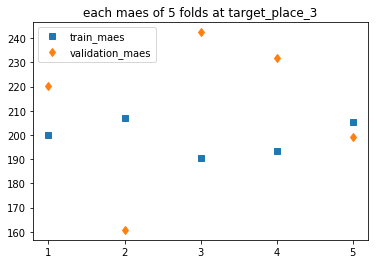

In [117]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [118]:
predict_data.to_csv('data/layer_1/layer_1_SOLA0'+str(target_place)+'.csv', index=False)
train_data.to_csv('data/layer_1/layer_1_train_SOLA0'+str(target_place)+'.csv', index=False)